<a href="https://colab.research.google.com/github/SanjanaRitika/TextToCode_seq2seq/blob/main/text2code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
!pip -q install datasets sacrebleu evaluate


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.8/100.8 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 9.5 MB/s eta 0:00:00


In [14]:
import random, math, re, os, time
import numpy as np
from dataclasses import dataclass
from typing import List, Tuple, Dict

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from datasets import load_dataset
import sacrebleu


In [15]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

In [16]:
DATASET_CANDIDATES = [
    "Nan-Do/code-search-net-python",
    "code_search_net",  # official HF name sometimes
]

ds = None
last_err = None
for name in DATASET_CANDIDATES:
    try:
        ds = load_dataset(name)
        print("Loaded:", name)
        break
    except Exception as e:
        last_err = e

if ds is None:
    raise RuntimeError(f"Could not load dataset from candidates. Last error: {last_err}")

ds


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00004-ee77a7de79eb2a(…):   0%|          | 0.00/155M [00:00<?, ?B/s]

data/train-00001-of-00004-648b3bede2edf6(…):   0%|          | 0.00/139M [00:00<?, ?B/s]

data/train-00002-of-00004-1dfd72b171e6b2(…):   0%|          | 0.00/153M [00:00<?, ?B/s]

data/train-00003-of-00004-184ab6d0e3c690(…):   0%|          | 0.00/151M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/455243 [00:00<?, ? examples/s]

Loaded: Nan-Do/code-search-net-python


DatasetDict({
    train: Dataset({
        features: ['repo', 'path', 'func_name', 'original_string', 'language', 'code', 'code_tokens', 'docstring', 'docstring_tokens', 'sha', 'url', 'partition', 'summary'],
        num_rows: 455243
    })
})

In [17]:
print(ds)
print(ds["train"].column_names)


DatasetDict({
    train: Dataset({
        features: ['repo', 'path', 'func_name', 'original_string', 'language', 'code', 'code_tokens', 'docstring', 'docstring_tokens', 'sha', 'url', 'partition', 'summary'],
        num_rows: 455243
    })
})
['repo', 'path', 'func_name', 'original_string', 'language', 'code', 'code_tokens', 'docstring', 'docstring_tokens', 'sha', 'url', 'partition', 'summary']


In [18]:
def extract_pair(example):
    # common patterns
    for doc_key in ["docstring", "func_documentation_string", "doc"]:
        if doc_key in example and example[doc_key]:
            doc = example[doc_key]
            break
    else:
        doc = ""

    for code_key in ["code", "func_code_string", "function", "content"]:
        if code_key in example and example[code_key]:
            code = example[code_key]
            break
    else:
        code = ""

    # some datasets store dicts
    if isinstance(doc, dict):
        doc = doc.get("value", "")
    if isinstance(code, dict):
        code = code.get("value", "")

    return doc, code

# quick sanity check
for i in range(3):
    d, c = extract_pair(ds["train"][i])
    print("DOC:", d[:120].replace("\n"," "))
    print("CODE:", c[:120].replace("\n"," "))
    print("---")


DOC: Trains a k-nearest neighbors classifier for face recognition.      :param train_dir: directory that contains a sub-direc
CODE: def train(train_dir, model_save_path=None, n_neighbors=None, knn_algo='ball_tree', verbose=False):     """     Trains a 
---
DOC: Recognizes faces in given image using a trained KNN classifier      :param X_img_path: path to image to be recognized   
CODE: def predict(X_img_path, knn_clf=None, model_path=None, distance_threshold=0.6):     """     Recognizes faces in given im
---
DOC: Shows the face recognition results visually.      :param img_path: path to image to be recognized     :param predictions
CODE: def show_prediction_labels_on_image(img_path, predictions):     """     Shows the face recognition results visually.    
---


In [19]:
TRAIN_N = 8000
VAL_N   = 1000
TEST_N  = 1000

train_raw = ds["train"].shuffle(seed=42).select(range(TRAIN_N))
val_raw   = ds["validation"].shuffle(seed=42).select(range(min(VAL_N, len(ds["validation"]))))
test_raw  = ds["test"].shuffle(seed=42).select(range(min(TEST_N, len(ds["test"]))))

len(train_raw), len(val_raw), len(test_raw)


KeyError: 'validation'

In [ ]:
TOKEN_RE = re.compile(r"\w+|[^\w\s]", re.UNICODE)

def tokenize(text: str) -> List[str]:
    text = text.strip()
    if not text:
        return []
    return TOKEN_RE.findall(text)

PAD, BOS, EOS, UNK = "<pad>", "<bos>", "<eos>", "<unk>"

def build_vocab(pairs, max_size=30000, min_freq=2):
    from collections import Counter
    cnt = Counter()
    for doc, code in pairs:
        cnt.update(tokenize(doc))
        cnt.update(tokenize(code))
    vocab = [PAD, BOS, EOS, UNK]
    for tok, f in cnt.most_common():
        if f < min_freq:
            break
        if tok in vocab:
            continue
        vocab.append(tok)
        if len(vocab) >= max_size:
            break
    stoi = {t:i for i,t in enumerate(vocab)}
    itos = {i:t for t,i in stoi.items()}
    return vocab, stoi, itos

# Build vocab from training only (standard)
train_pairs = [extract_pair(ex) for ex in train_raw]
vocab, stoi, itos = build_vocab(train_pairs, max_size=30000, min_freq=2)
vocab_size = len(vocab)
vocab_size


In [20]:
TRAIN_N = 8000
VAL_N   = 1000
TEST_N  = 1000

train_raw = ds["train"].shuffle(seed=42).select(range(min(TRAIN_N, len(ds["train"]))))

# ---- validation split handling ----
if "validation" in ds:
    val_raw = ds["validation"].shuffle(seed=42).select(
        range(min(VAL_N, len(ds["validation"])))
    )

elif "valid" in ds:
    val_raw = ds["valid"].shuffle(seed=42).select(
        range(min(VAL_N, len(ds["valid"])))
    )

else:
    # create validation from train (10%)
    split_idx = int(0.9 * len(train_raw))
    val_raw = train_raw.select(range(split_idx, len(train_raw)))
    train_raw = train_raw.select(range(split_idx))
    print("No validation split found — created from train set.")

# ---- test split handling ----
if "test" in ds:
    test_raw = ds["test"].shuffle(seed=42).select(
        range(min(TEST_N, len(ds["test"])))
    )
else:
    # fallback if test missing
    test_raw = val_raw
    print("No test split found — using validation as test.")


No validation split found — created from train set.
No test split found — using validation as test.


In [21]:
class CodeGenDataset(Dataset):
    def __init__(self, enc_list: List[EncodedExample]):
        self.data = enc_list
    def __len__(self): return len(self.data)
    def __getitem__(self, idx):
        ex = self.data[idx]
        return (
            torch.tensor(ex.src_ids, dtype=torch.long),
            torch.tensor(ex.tgt_in_ids, dtype=torch.long),
            torch.tensor(ex.tgt_out_ids, dtype=torch.long),
            torch.tensor(ex.src_len, dtype=torch.long),
            torch.tensor(ex.tgt_len, dtype=torch.long),
        )

BATCH_SIZE = 64

train_loader = DataLoader(CodeGenDataset(train_enc), batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(CodeGenDataset(val_enc), batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(CodeGenDataset(test_enc), batch_size=BATCH_SIZE, shuffle=False)


NameError: name 'EncodedExample' is not defined

In [22]:
print(ds)
print(ds.keys())


DatasetDict({
    train: Dataset({
        features: ['repo', 'path', 'func_name', 'original_string', 'language', 'code', 'code_tokens', 'docstring', 'docstring_tokens', 'sha', 'url', 'partition', 'summary'],
        num_rows: 455243
    })
})
dict_keys(['train'])


In [23]:
TRAIN_N = 8000
VAL_N   = 1000
TEST_N  = 1000

train_raw = ds["train"].shuffle(seed=42).select(range(min(TRAIN_N, len(ds["train"]))))

# ---- validation split handling ----
if "validation" in ds:
    val_raw = ds["validation"].shuffle(seed=42).select(
        range(min(VAL_N, len(ds["validation"])))
    )

elif "valid" in ds:
    val_raw = ds["valid"].shuffle(seed=42).select(
        range(min(VAL_N, len(ds["valid"])))
    )

else:
    # create validation from train (10%)
    split_idx = int(0.9 * len(train_raw))
    val_raw = train_raw.select(range(split_idx, len(train_raw)))
    train_raw = train_raw.select(range(split_idx))
    print("No validation split found — created from train set.")

# ---- test split handling ----
if "test" in ds:
    test_raw = ds["test"].shuffle(seed=42).select(
        range(min(TEST_N, len(ds["test"])))
    )
else:
    # fallback if test missing
    test_raw = val_raw
    print("No test split found — using validation as test.")


No validation split found — created from train set.
No test split found — using validation as test.


In [24]:
TOKEN_RE = re.compile(r"\w+|[^\w\s]", re.UNICODE)

def tokenize(text: str) -> List[str]:
    text = text.strip()
    if not text:
        return []
    return TOKEN_RE.findall(text)

PAD, BOS, EOS, UNK = "<pad>", "<bos>", "<eos>", "<unk>"

def build_vocab(pairs, max_size=30000, min_freq=2):
    from collections import Counter
    cnt = Counter()
    for doc, code in pairs:
        cnt.update(tokenize(doc))
        cnt.update(tokenize(code))
    vocab = [PAD, BOS, EOS, UNK]
    for tok, f in cnt.most_common():
        if f < min_freq:
            break
        if tok in vocab:
            continue
        vocab.append(tok)
        if len(vocab) >= max_size:
            break
    stoi = {t:i for i,t in enumerate(vocab)}
    itos = {i:t for t,i in stoi.items()}
    return vocab, stoi, itos

# Build vocab from training only (standard)
train_pairs = [extract_pair(ex) for ex in train_raw]
vocab, stoi, itos = build_vocab(train_pairs, max_size=30000, min_freq=2)
vocab_size = len(vocab)
vocab_size


30000

In [25]:
MAX_SRC = 50
MAX_TGT = 80

def encode(tokens: List[str], max_len: int):
    tokens = tokens[:max_len]
    ids = [stoi.get(t, stoi[UNK]) for t in tokens]
    return ids

def add_bos_eos(ids: List[int], max_len: int):
    ids = [stoi[BOS]] + ids + [stoi[EOS]]
    # keep within max_len+2 budget
    ids = ids[:max_len+2]
    return ids

def pad(ids: List[int], max_total_len: int):
    if len(ids) < max_total_len:
        ids = ids + [stoi[PAD]]*(max_total_len - len(ids))
    return ids

@dataclass
class EncodedExample:
    src_ids: List[int]
    tgt_in_ids: List[int]   # decoder input (starts with BOS)
    tgt_out_ids: List[int]  # labels (shifted, ends with EOS)
    src_len: int
    tgt_len: int
    raw_doc: str
    raw_code: str

def preprocess_pair(doc, code):
    src_tok = tokenize(doc)
    tgt_tok = tokenize(code)

    src_ids = add_bos_eos(encode(src_tok, MAX_SRC), MAX_SRC)
    tgt_ids = add_bos_eos(encode(tgt_tok, MAX_TGT), MAX_TGT)

    # decoder: input is all but last, output is all but first
    tgt_in  = tgt_ids[:-1]
    tgt_out = tgt_ids[1:]

    src_len = min(len(src_ids), MAX_SRC+2)
    tgt_len = min(len(tgt_in), MAX_TGT+1)

    src_ids = pad(src_ids, MAX_SRC+2)
    tgt_in  = pad(tgt_in,  MAX_TGT+1)
    tgt_out = pad(tgt_out, MAX_TGT+1)

    return EncodedExample(src_ids, tgt_in, tgt_out, src_len, tgt_len, doc, code)

train_enc = [preprocess_pair(*extract_pair(ex)) for ex in train_raw]
val_enc   = [preprocess_pair(*extract_pair(ex)) for ex in val_raw]
test_enc  = [preprocess_pair(*extract_pair(ex)) for ex in test_raw]

len(train_enc), len(val_enc), len(test_enc)


(7200, 800, 800)

In [26]:
class CodeGenDataset(Dataset):
    def __init__(self, enc_list: List[EncodedExample]):
        self.data = enc_list
    def __len__(self): return len(self.data)
    def __getitem__(self, idx):
        ex = self.data[idx]
        return (
            torch.tensor(ex.src_ids, dtype=torch.long),
            torch.tensor(ex.tgt_in_ids, dtype=torch.long),
            torch.tensor(ex.tgt_out_ids, dtype=torch.long),
            torch.tensor(ex.src_len, dtype=torch.long),
            torch.tensor(ex.tgt_len, dtype=torch.long),
        )

BATCH_SIZE = 64

train_loader = DataLoader(CodeGenDataset(train_enc), batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(CodeGenDataset(val_enc), batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(CodeGenDataset(test_enc), batch_size=BATCH_SIZE, shuffle=False)


In [27]:
def token_accuracy(logits, targets, pad_idx):
    # logits: [B, T, V], targets: [B, T]
    preds = logits.argmax(-1)
    mask = targets != pad_idx
    correct = (preds == targets) & mask
    return correct.sum().item() / (mask.sum().item() + 1e-9)

def ids_to_text(ids: List[int]):
    toks = []
    for i in ids:
        if i == stoi[EOS]:
            break
        if i in (stoi[PAD], stoi[BOS]):
            continue
        toks.append(itos.get(int(i), UNK))
    # join with space; for code it won’t be perfect but works for BLEU + inspection
    return " ".join(toks)


In [28]:
class EncoderRNN(nn.Module):
    def __init__(self, vocab_size, emb_dim, hid_dim):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim, padding_idx=stoi[PAD])
        self.rnn = nn.RNN(emb_dim, hid_dim, batch_first=True)

    def forward(self, src, src_len):
        # src: [B, S]
        emb = self.emb(src)
        out, h = self.rnn(emb)  # out: [B,S,H], h: [1,B,H]
        return out, h

class DecoderRNN(nn.Module):
    def __init__(self, vocab_size, emb_dim, hid_dim):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim, padding_idx=stoi[PAD])
        self.rnn = nn.RNN(emb_dim, hid_dim, batch_first=True)
        self.fc  = nn.Linear(hid_dim, vocab_size)

    def forward(self, tgt_in, h):
        emb = self.emb(tgt_in)          # [B,T,E]
        out, h = self.rnn(emb, h)       # [B,T,H]
        logits = self.fc(out)           # [B,T,V]
        return logits, h

class Seq2SeqNoAttn(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, src, src_len, tgt_in):
        _, h = self.encoder(src, src_len)
        logits, _ = self.decoder(tgt_in, h)
        return logits


In [29]:
class EncoderLSTM(nn.Module):
    def __init__(self, vocab_size, emb_dim, hid_dim):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim, padding_idx=stoi[PAD])
        self.lstm = nn.LSTM(emb_dim, hid_dim, batch_first=True)

    def forward(self, src, src_len):
        emb = self.emb(src)
        out, (h, c) = self.lstm(emb)  # h,c: [1,B,H]
        return out, (h, c)

class DecoderLSTM(nn.Module):
    def __init__(self, vocab_size, emb_dim, hid_dim):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim, padding_idx=stoi[PAD])
        self.lstm = nn.LSTM(emb_dim, hid_dim, batch_first=True)
        self.fc  = nn.Linear(hid_dim, vocab_size)

    def forward(self, tgt_in, hc):
        emb = self.emb(tgt_in)
        out, hc = self.lstm(emb, hc)
        logits = self.fc(out)
        return logits, hc

class Seq2SeqLSTMNoAttn(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, src, src_len, tgt_in):
        _, hc = self.encoder(src, src_len)
        logits, _ = self.decoder(tgt_in, hc)
        return logits


In [30]:
class BahdanauAttention(nn.Module):
    def __init__(self, enc_dim, dec_dim, attn_dim):
        super().__init__()
        self.W_enc = nn.Linear(enc_dim, attn_dim, bias=False)
        self.W_dec = nn.Linear(dec_dim, attn_dim, bias=False)
        self.v     = nn.Linear(attn_dim, 1, bias=False)

    def forward(self, enc_out, dec_h, src_mask):
        # enc_out: [B,S,enc_dim], dec_h: [B,dec_dim], mask: [B,S] (1 for valid)
        # score = v^T tanh(W_enc(enc_out) + W_dec(dec_h))
        e = self.W_enc(enc_out) + self.W_dec(dec_h).unsqueeze(1)  # [B,S,A]
        scores = self.v(torch.tanh(e)).squeeze(-1)                # [B,S]

        scores = scores.masked_fill(src_mask == 0, -1e9)
        attn = torch.softmax(scores, dim=-1)                      # [B,S]
        ctx = torch.bmm(attn.unsqueeze(1), enc_out).squeeze(1)    # [B,enc_dim]
        return ctx, attn

class EncoderBiLSTM(nn.Module):
    def __init__(self, vocab_size, emb_dim, hid_dim):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim, padding_idx=stoi[PAD])
        self.lstm = nn.LSTM(emb_dim, hid_dim, batch_first=True, bidirectional=True)

    def forward(self, src, src_len):
        emb = self.emb(src)
        out, (h, c) = self.lstm(emb)  # out: [B,S,2H], h,c: [2,B,H]
        return out, (h, c)

class DecoderAttnLSTM(nn.Module):
    def __init__(self, vocab_size, emb_dim, enc_out_dim, hid_dim, attn_dim=256):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim, padding_idx=stoi[PAD])
        self.attn = BahdanauAttention(enc_out_dim, hid_dim, attn_dim)
        self.lstm = nn.LSTM(emb_dim + enc_out_dim, hid_dim, batch_first=True)
        self.fc   = nn.Linear(hid_dim, vocab_size)

    def forward(self, tgt_in, enc_out, hc, src_mask):
        # teacher forcing full sequence
        B, T = tgt_in.shape
        emb = self.emb(tgt_in)  # [B,T,E]
        h, c = hc
        h = h.squeeze(0)        # [B,H]
        c = c.squeeze(0)        # [B,H]

        all_logits = []
        all_attn = []

        for t in range(T):
            ctx, attn_w = self.attn(enc_out, h, src_mask)   # ctx: [B,enc_dim]
            x = torch.cat([emb[:, t, :], ctx], dim=-1).unsqueeze(1)  # [B,1,E+enc]
            out, (h1, c1) = self.lstm(x, (h.unsqueeze(0), c.unsqueeze(0)))
            h = h1.squeeze(0); c = c1.squeeze(0)
            logits = self.fc(out.squeeze(1))                # [B,V]
            all_logits.append(logits.unsqueeze(1))
            all_attn.append(attn_w.unsqueeze(1))

        logits = torch.cat(all_logits, dim=1)  # [B,T,V]
        attn   = torch.cat(all_attn, dim=1)    # [B,T,S]
        return logits, attn

class Seq2SeqAttn(nn.Module):
    def __init__(self, encoder_bi, decoder_attn, enc_hid_dim, dec_hid_dim):
        super().__init__()
        self.encoder = encoder_bi
        self.decoder = decoder_attn
        # bridge biLSTM states -> decoder initial
        self.bridge_h = nn.Linear(enc_hid_dim*2, dec_hid_dim)
        self.bridge_c = nn.Linear(enc_hid_dim*2, dec_hid_dim)

    def forward(self, src, src_len, tgt_in):
        enc_out, (h, c) = self.encoder(src, src_len)  # h,c: [2,B,H]
        # concat directions
        h_cat = torch.cat([h[0], h[1]], dim=-1)  # [B,2H]
        c_cat = torch.cat([c[0], c[1]], dim=-1)
        h0 = torch.tanh(self.bridge_h(h_cat)).unsqueeze(0)  # [1,B,H]
        c0 = torch.tanh(self.bridge_c(c_cat)).unsqueeze(0)

        src_mask = (src != stoi[PAD]).long()  # [B,S]
        logits, attn = self.decoder(tgt_in, enc_out, (h0, c0), src_mask)
        return logits, attn


In [31]:
def run_epoch(model, loader, optimizer=None):
    is_train = optimizer is not None
    model.train() if is_train else model.eval()

    ce = nn.CrossEntropyLoss(ignore_index=stoi[PAD])
    total_loss = 0.0
    total_acc = 0.0
    n_batches = 0

    for src, tgt_in, tgt_out, src_len, tgt_len in loader:
        src, tgt_in, tgt_out = src.to(device), tgt_in.to(device), tgt_out.to(device)

        if is_train:
            optimizer.zero_grad()

        with torch.set_grad_enabled(is_train):
            out = model(src, src_len, tgt_in)
            if isinstance(out, tuple):
                logits = out[0]
            else:
                logits = out

            loss = ce(logits.reshape(-1, logits.size(-1)), tgt_out.reshape(-1))
            acc  = token_accuracy(logits, tgt_out, stoi[PAD])

            if is_train:
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()

        total_loss += loss.item()
        total_acc  += acc
        n_batches += 1

    return total_loss / n_batches, total_acc / n_batches


In [32]:
def train_model(model, epochs=8, lr=1e-3, ckpt_path="model.pt"):
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    history = {"train_loss":[], "val_loss":[], "train_acc":[], "val_acc":[]}

    best_val = float("inf")
    for ep in range(1, epochs+1):
        tr_loss, tr_acc = run_epoch(model, train_loader, optimizer)
        va_loss, va_acc = run_epoch(model, val_loader, None)

        history["train_loss"].append(tr_loss)
        history["val_loss"].append(va_loss)
        history["train_acc"].append(tr_acc)
        history["val_acc"].append(va_acc)

        print(f"Epoch {ep}: train loss {tr_loss:.4f} acc {tr_acc:.4f} | val loss {va_loss:.4f} acc {va_acc:.4f}")

        if va_loss < best_val:
            best_val = va_loss
            torch.save(model.state_dict(), ckpt_path)
            print("  saved:", ckpt_path)

    return history


In [34]:
EMB_DIM = 256
HID_DIM = 256

# Model 1
m1 = Seq2SeqNoAttn(
    EncoderRNN(vocab_size, EMB_DIM, HID_DIM),
    DecoderRNN(vocab_size, EMB_DIM, HID_DIM)
)

# Model 2
m2 = Seq2SeqLSTMNoAttn(
    EncoderLSTM(vocab_size, EMB_DIM, HID_DIM),
    DecoderLSTM(vocab_size, EMB_DIM, HID_DIM)
)

# Model 3
enc3 = EncoderBiLSTM(vocab_size, EMB_DIM, HID_DIM)
# encoder out dim = 2*HID_DIM
dec3 = DecoderAttnLSTM(vocab_size, EMB_DIM, enc_out_dim=2*HID_DIM, hid_dim=HID_DIM, attn_dim=256)
m3 = Seq2SeqAttn(enc3, dec3, enc_hid_dim=HID_DIM, dec_hid_dim=HID_DIM)

hist1 = train_model(m1, epochs=8, ckpt_path="m1_rnn.pt")
hist2 = train_model(m2, epochs=8, ckpt_path="m2_lstm.pt")
hist3 = train_model(m3, epochs=8, ckpt_path="m3_attn.pt")


Epoch 1: train loss 5.6051 acc 0.2328 | val loss 4.2491 acc 0.3190
  saved: m1_rnn.pt
Epoch 2: train loss 4.4018 acc 0.3275 | val loss 3.9233 acc 0.3582
  saved: m1_rnn.pt
Epoch 3: train loss 4.1009 acc 0.3562 | val loss 3.7792 acc 0.3729
  saved: m1_rnn.pt
Epoch 4: train loss 3.9123 acc 0.3739 | val loss 3.6925 acc 0.3864
  saved: m1_rnn.pt
Epoch 5: train loss 3.7722 acc 0.3874 | val loss 3.6271 acc 0.3973
  saved: m1_rnn.pt
Epoch 6: train loss 3.6571 acc 0.3975 | val loss 3.5955 acc 0.4039
  saved: m1_rnn.pt
Epoch 7: train loss 3.5559 acc 0.4060 | val loss 3.5664 acc 0.4079
  saved: m1_rnn.pt
Epoch 8: train loss 3.4653 acc 0.4135 | val loss 3.5400 acc 0.4121
  saved: m1_rnn.pt
Epoch 1: train loss 5.8458 acc 0.2111 | val loss 4.4192 acc 0.2963
  saved: m2_lstm.pt
Epoch 2: train loss 4.5512 acc 0.3126 | val loss 4.0397 acc 0.3408
  saved: m2_lstm.pt
Epoch 3: train loss 4.2327 acc 0.3445 | val loss 3.8589 acc 0.3637
  saved: m2_lstm.pt
Epoch 4: train loss 4.0366 acc 0.3650 | val loss 3.

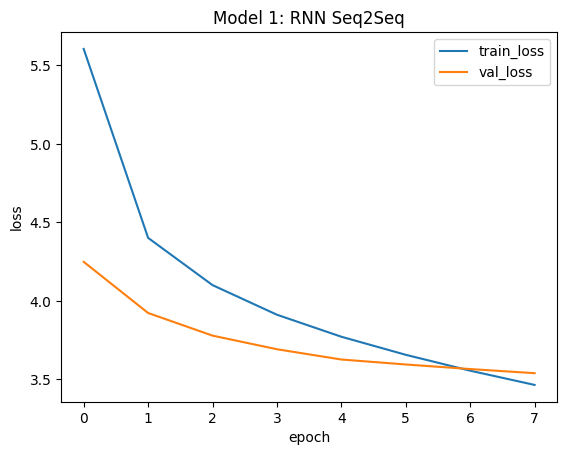

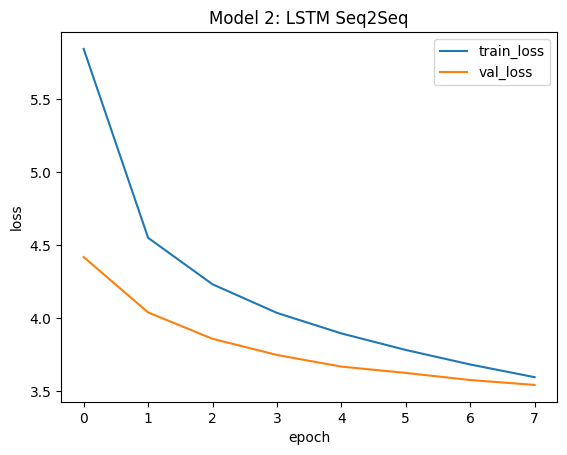

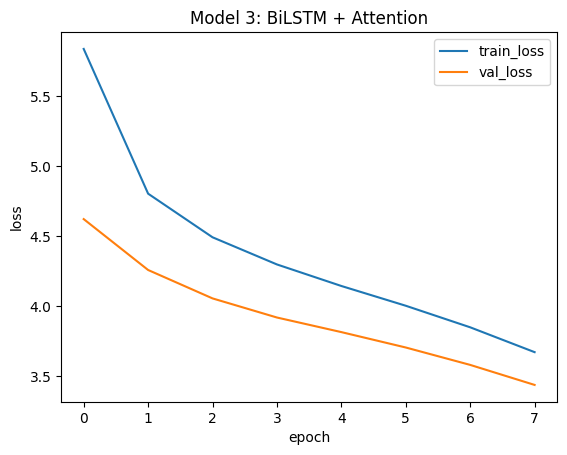

In [35]:
import matplotlib.pyplot as plt

def plot_history(hist, title):
    plt.figure()
    plt.plot(hist["train_loss"], label="train_loss")
    plt.plot(hist["val_loss"], label="val_loss")
    plt.title(title)
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.legend()
    plt.show()

plot_history(hist1, "Model 1: RNN Seq2Seq")
plot_history(hist2, "Model 2: LSTM Seq2Seq")
plot_history(hist3, "Model 3: BiLSTM + Attention")
